In [1]:
# Внимание!!! Важно, что бы файлы с данными и исполняемый файл находились в одной папке, 
# тогда пути к тестовым и тренировочным наборам будут содержать только имена файлов.
# 
# В пути к тренировочным и тестовым данным запрежается использовать абсалютную адресацию, 
# то есть адресацию, в которой присутствуют имена папок. Путь должен содержать только имя файла.
#
# Напоминание: под моделью машинного обучения понимаются все действия с исходными данными, 
# которые необходимо произвести, что бы сопоставить признаки целевому значению.

### Область работы 1 (библиотеки)

In [2]:
# Данный блок в области 1 выполняется преподавателем
# 
# данный блок предназначен только для подключения необходимых библиотек
# запрещается подключать библиотеки в других блоках
# запрещается скрывать предупреждения системы
# установка дополнительных библиотек размещается прямо здесь (обязательно закоментированы)
# pip install

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import PolynomialFeatures, QuantileTransformer, PowerTransformer
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet, BayesianRidge # по итогу не используются
from sklearn.neighbors import KNeighborsRegressor
import category_encoders as ce
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import boxcox # на всякий случай, ничего не дало его применение
#pip install category_encoders

### Область работы 2 (выполнение лучшей модели)

In [4]:
# Данный блок(и) в области 2 выполняется преподавателем
#
# В области находится одна, единственная, итоговая модель машинного обучения с однозначными, 
# зафиксированными параметрами
#
# В данной области категорически запрещается искать, выбирать, улучшать, оптимизировать, 
# тюниговать и т.д. модель машинного обучения

### Функция для отрисовки

In [5]:
def plot_2_error(y_true, y_predicted):
    residuals = (y_true - y_predicted)/y_predicted
    max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
    max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
    max_true, max_pred = y_true[max_idx], y_predicted[max_idx]
    mape = mean_absolute_percentage_error(y_true, y_predicted)
    print("Max Error:", "{:,.0f}".format(max_error))
    print(' ')
    print('----------------------')
    print("   MAPE Error:", "{:,.2f}".format(mape*100))
    print('----------------------')

    ## Plot predicted vs true
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    from statsmodels.graphics.api import abline_plot
    ax[0].scatter(y_predicted, y_true, color="black", alpha=0.25)
    abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
    ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error, color='red', linestyle='--', alpha=0.7, label="max error")
    ax[0].grid(True)
    ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
    ax[0].legend()

    ## Plot predicted vs residuals
    ax[1].scatter(y_predicted, residuals, color="red", alpha=0.25)
    ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black', linestyle='--', alpha=0.7, label="max error")
    ax[1].grid(True)
    ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
    ax[1].hlines(y=0, xmin=np.min(y_predicted), xmax=np.max(y_predicted))
    ax[1].legend()
    plt.show()

### Загружаю данные, дропаю дубликаты

In [6]:
df= pd.read_csv('train.csv')
df = df.drop_duplicates()
df

,size,color,clarity,cut,symmetry,polish,depth_percent,table_percent,meas_length,meas_width,meas_depth,total_sales_price
0,0.50,K,SI2,Excellent,Excellent,Excellent,61.4,55.0,5.10,5.12,3.14,990
1,0.50,E,VVS2,Excellent,Excellent,Very Good,61.9,60.0,5.06,5.09,3.14,3384
2,0.35,G,VS2,Excellent,Excellent,Excellent,63.0,55.0,4.47,4.51,2.83,1154
3,0.30,E,SI2,Excellent,Excellent,Excellent,63.2,57.0,4.24,4.27,2.69,886
4,0.30,F,VS2,Very Good,Very Good,Excellent,63.4,61.0,4.24,4.26,2.69,864
...,...,...,...,...,...,...,...,...,...,...,...,...
67593,0.30,D,SI2,Very Good,Very Good,Excellent,64.4,55.0,4.19,4.21,2.71,640
67594,0.60,H,VS2,Excellent,Excellent,Excellent,62.4,59.0,5.40,5.42,3.38,2932
67595,0.36,L,VVS2,Excellent,Excellent,Excellent,62.3,55.0,4.55,4.59,2.85,788
67596,0.41,J,SI1,Excellent,Excellent,Excellent,62.7,57.0,4.74,4.78,2.98,1074


### Проверю на наличие NaN и узнаю Dtypes

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67406 entries, 0 to 67597
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   size               67406 non-null  float64
 1   color              67406 non-null  object 
 2   clarity            67406 non-null  object 
 3   cut                67406 non-null  object 
 4   symmetry           67406 non-null  object 
 5   polish             67406 non-null  object 
 6   depth_percent      67406 non-null  float64
 7   table_percent      67406 non-null  float64
 8   meas_length        67406 non-null  float64
 9   meas_width         67406 non-null  float64
 10  meas_depth         67406 non-null  float64
 11  total_sales_price  67406 non-null  int64  
dtypes: float64(6), int64(1), object(5)
memory usage: 6.7+ MB


### Просмотр описательных статистик

In [8]:
df.describe()

,size,depth_percent,table_percent,meas_length,meas_width,meas_depth,total_sales_price
count,67406.000000,67406.000000,67406.000000,67406.000000,67406.000000,67406.000000,67406.000000
mean,0.504200,62.108139,57.791947,4.911914,4.943721,3.060998,2754.368068
std,0.306289,1.308627,1.852402,0.869308,0.874522,0.545386,3340.749253
min,0.150000,55.000000,0.000000,2.270000,3.420000,0.000000,242.000000
25%,0.300000,61.400000,56.000000,4.290000,4.310000,2.680000,898.000000
50%,0.400000,62.300000,58.000000,4.600000,4.640000,2.880000,1236.000000
75%,0.570000,62.800000,59.000000,5.290000,5.327500,3.290000,3206.000000
max,2.000000,66.500000,67.000000,8.180000,8.230000,6.860000,19996.000000


In [9]:
df.head()

,size,color,clarity,cut,symmetry,polish,depth_percent,table_percent,meas_length,meas_width,meas_depth,total_sales_price
0,0.50,K,SI2,Excellent,Excellent,Excellent,61.4,55.0,5.10,5.12,3.14,990
1,0.50,E,VVS2,Excellent,Excellent,Very Good,61.9,60.0,5.06,5.09,3.14,3384
2,0.35,G,VS2,Excellent,Excellent,Excellent,63.0,55.0,4.47,4.51,2.83,1154
3,0.30,E,SI2,Excellent,Excellent,Excellent,63.2,57.0,4.24,4.27,2.69,886
4,0.30,F,VS2,Very Good,Very Good,Excellent,63.4,61.0,4.24,4.26,2.69,864


### Делаю то, о чем говорили на семинаре - меняю длину с глубиной

In [10]:
indices = df[df['meas_depth'] > df['meas_length']].index
df.loc[indices, ['meas_length', 'meas_depth']] = df.loc[indices, ['meas_depth', 'meas_length']].values

### Удаляю выбросы через межквартильный размах, замена выбросов на медиану не помогла

In [11]:
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
df

,size,color,clarity,cut,symmetry,polish,depth_percent,table_percent,meas_length,meas_width,meas_depth,total_sales_price
0,0.50,K,SI2,Excellent,Excellent,Excellent,61.4,55.0,5.10,5.12,3.14,990
1,0.50,E,VVS2,Excellent,Excellent,Very Good,61.9,60.0,5.06,5.09,3.14,3384
2,0.35,G,VS2,Excellent,Excellent,Excellent,63.0,55.0,4.47,4.51,2.83,1154
3,0.30,E,SI2,Excellent,Excellent,Excellent,63.2,57.0,4.24,4.27,2.69,886
4,0.30,F,VS2,Very Good,Very Good,Excellent,63.4,61.0,4.24,4.26,2.69,864
...,...,...,...,...,...,...,...,...,...,...,...,...
67593,0.30,D,SI2,Very Good,Very Good,Excellent,64.4,55.0,4.19,4.21,2.71,640
67594,0.60,H,VS2,Excellent,Excellent,Excellent,62.4,59.0,5.40,5.42,3.38,2932
67595,0.36,L,VVS2,Excellent,Excellent,Excellent,62.3,55.0,4.55,4.59,2.85,788
67596,0.41,J,SI1,Excellent,Excellent,Excellent,62.7,57.0,4.74,4.78,2.98,1074


### Создаю листые по типу данных:  категориальные, числовые, и отдельно глубину/ширину/длину

In [12]:
cat_features = ['cut', 'color', 'symmetry', 'polish']
axis_features = ['meas_length', 'meas_width', 'meas_depth']
num_features = ['size', 'depth_percent', 'table_percent']

### Сплитую данные на train и test

In [13]:
y = np.array(df.total_sales_price)
X = df.drop(columns=['total_sales_price'])

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.3)

### Создаю трансформера

In [14]:
axis_transformer = Pipeline(steps=[
    ('missing_num', IterativeImputer(missing_values=0, max_iter=20)), 
    ('polynom', PolynomialFeatures(2, include_bias=False)),
    ('scaler', StandardScaler())
])

num = Pipeline(steps=[
    ('missing_num', IterativeImputer(missing_values=0, max_iter=20)),
    ('scaler', StandardScaler())
])

clarity_map = [{
    'col': 'clarity',
    'mapping': {'FL':10, 'IF':9, 'VVS1':8, 'VVS2':7, 'VS1':6, 'VS2':5, 
               'SI1':4, 'SI2':3, 'I1':2, 'I2':1, 'I3':0}
}]

clarity_transformer = Pipeline(steps=[
    ('missing_num', SimpleImputer(strategy='most_frequent')),
    ('ce', ce.OrdinalEncoder(mapping=clarity_map)),
    ('scaler', MinMaxScaler())
])

CT = ColumnTransformer([
        ("axis_transformer", axis_transformer, axis_features),
        ("num", num, num_features),
        ("cat", OneHotEncoder(sparse_output=False).set_output(transform="pandas"), cat_features),
        ("ordinal_map", clarity_transformer, ['clarity'])
    ]).set_output(transform='pandas')

display(CT)

ct = CT.fit_transform(X_train)
pd.DataFrame(ct).head()

ColumnTransformer(transformers=[('axis_transformer',
                                 Pipeline(steps=[('missing_num',
                                                  IterativeImputer(max_iter=20,
                                                                   missing_values=0)),
                                                 ('polynom',
                                                  PolynomialFeatures(include_bias=False)),
                                                 ('scaler', StandardScaler())]),
                                 ['meas_length', 'meas_width', 'meas_depth']),
                                ('num',
                                 Pipeline(steps=[('missing_num',
                                                  IterativeImputer(max_iter=20,
                                                                   missing_values=0)),
                                                 ('scaler'...
                                 ['size', 'depth_percent', 'table_percent']),
                                ('cat', OneHotEncoder(sparse_output=False),
                                 ['cut', 'color', 'symmetry', 'polish']),
                                ('ordinal_map',
                                 Pipeline(steps=[('missing_num',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ce',
                                                  OrdinalEncoder(mapping=[{'col': 'clarity',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': FL      10
IF       9
VVS1     8
VVS2     7
VS1      6
VS2      5
SI1      4
SI2      3
I1       2
I2       1
I3       0
dtype: int64}])),
                                                 ('scaler', MinMaxScaler())]),
                                 ['clarity'])])

,axis_transformer__meas_length,axis_transformer__meas_width,axis_transformer__meas_depth,axis_transformer__meas_length^2,axis_transformer__meas_length meas_width,axis_transformer__meas_length meas_depth,axis_transformer__meas_width^2,axis_transformer__meas_width meas_depth,axis_transformer__meas_depth^2,num__size,...,cat__color_I,cat__color_J,cat__color_K,cat__color_L,cat__color_M,cat__symmetry_Excellent,cat__symmetry_Very Good,cat__polish_Excellent,cat__polish_Very Good,ordinal_map__clarity
17460,-0.194950,-0.192640,-0.175880,-0.236941,-0.235872,-0.228843,-0.234793,-0.227756,-0.220712,-0.254475,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.444444
11141,-0.637295,-0.653012,-0.601867,-0.646439,-0.653638,-0.633133,-0.660729,-0.640012,-0.616463,-0.648961,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.666667
31689,-0.574103,-0.569308,-0.470794,-0.589143,-0.587048,-0.543970,-0.584870,-0.541663,-0.496697,-0.570063,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.555556
24678,0.752933,0.811808,1.102084,0.706744,0.737603,0.896809,0.768445,0.927876,1.079405,0.928983,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.888889
15249,-0.616231,-0.590234,-0.667404,-0.627385,-0.615704,-0.653964,-0.603901,-0.642225,-0.675678,-0.648961,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.888889


### Создаю пайплайн

In [15]:
model_pipe = Pipeline([
                ('model', TransformedTargetRegressor(
                        regressor = Pipeline(steps=[
                                ('preproc', CT),
                                ('estimator', KNeighborsRegressor())
                            ]),
                        transformer=PowerTransformer(),
                        check_inverse = False)
                )])
model_pipe  

Pipeline(steps=[('model',
                 TransformedTargetRegressor(check_inverse=False,
                                            regressor=Pipeline(steps=[('preproc',
                                                                       ColumnTransformer(transformers=[('axis_transformer',
                                                                                                        Pipeline(steps=[('missing_num',
                                                                                                                         IterativeImputer(max_iter=20,
                                                                                                                                          missing_values=0)),
                                                                                                                        ('polynom',
                                                                                                                         PolynomialFeatures(include_bias=False)),
                                                                                                                        ('scaler',
                                                                                                                         StandardScaler())]),
                                                                                                        ['meas_length',
                                                                                                         'meas_width',
                                                                                                         '...
                                                                                                         'polish']),
                                                                                                       ('ordinal_map',
                                                                                                        Pipeline(steps=[('missing_num',
                                                                                                                         SimpleImputer(strategy='most_frequent')),
                                                                                                                        ('ce',
                                                                                                                         OrdinalEncoder(mapping=[{'col': 'clarity',
                                                                                                                                                  'data_type': dtype('O'),
                                                                                                                                                  'mapping': FL      10
IF       9
VVS1     8
VVS2     7
VS1      6
VS2      5
SI1      4
SI2      3
I1       2
I2       1
I3       0
dtype: int64}])),
                                                                                                                        ('scaler',
                                                                                                                         MinMaxScaler())]),
                                                                                                        ['clarity'])])),
                                                                      ('estimator',
                                                                       KNeighborsRegressor())]),
                                            transformer=PowerTransformer()))])

### Параметры решётки - поскольку она работает ну оооочень долго, а Knn-регрессия даёт лучшие результаты, то в итоговом коде подбора оставил только решётку с Knn

In [16]:
param_grid = [
    {'model__regressor__estimator': [KNeighborsRegressor()],
     'model__regressor__estimator__n_neighbors':  np.arange(1,10),
     'model__regressor__estimator__weights': ['uniform'],
     'model__regressor__estimator__p': [1, 2 , 3],
     'model__transformer': [PowerTransformer(), QuantileTransformer(n_quantiles=1000, output_distribution="uniform")]}
]

### Запуск решётки, метрика - MAPE

In [17]:
scores='neg_mean_absolute_percentage_error'
grid_2 = GridSearchCV(model_pipe, n_jobs=-1, param_grid=param_grid, scoring=scores)
grid_2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('model',
                                        TransformedTargetRegressor(check_inverse=False,
                                                                   regressor=Pipeline(steps=[('preproc',
                                                                                              ColumnTransformer(transformers=[('axis_transformer',
                                                                                                                               Pipeline(steps=[('missing_num',
                                                                                                                                                IterativeImputer(max_iter=20,
                                                                                                                                                                 missing_values=0)),
                                                                                                                                               ('polynom',
                                                                                                                                                PolynomialFeatures(include_bias=False)),
                                                                                                                                               ('scaler',
                                                                                                                                                StandardScaler())]),
                                                                                                                               ['meas...
             n_jobs=-1,
             param_grid=[{'model__regressor__estimator': [KNeighborsRegressor()],
                          'model__regressor__estimator__n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                          'model__regressor__estimator__p': [1, 2, 3],
                          'model__regressor__estimator__weights': ['uniform'],
                          'model__transformer': [PowerTransformer(),
                                                 QuantileTransformer()]}],
             scoring='neg_mean_absolute_percentage_error')

### Применяю лучшую модель

In [18]:
final = grid_2.best_estimator_

### Вывожу лучшие модели по test_score и отклонению

In [19]:
grid_result = pd.DataFrame(grid_2.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result

,28,22,26,20,34,32,16,38,40,23,...,13,49,6,7,5,4,3,2,1,0
mean_fit_time,0.179639,0.197645,0.204847,0.182441,0.173839,0.165436,0.17524,0.192845,0.176244,0.154035,...,0.167237,0.197155,0.186062,0.191244,0.165438,0.206447,0.200245,0.21505,0.203455,0.253261
std_fit_time,0.019371,0.023488,0.0239,0.022317,0.011359,0.005887,0.004876,0.010574,0.007627,0.010376,...,0.020038,0.036084,0.005824,0.041455,0.006439,0.014239,0.023665,0.004604,0.034321,0.017984
mean_score_time,104.357063,106.663462,1.259727,1.087245,106.141707,1.056438,106.545828,1.181266,115.721118,104.398517,...,4.961629,5.595847,4.843897,5.376215,105.160993,106.263457,1.174464,1.176664,4.807908,4.973349
std_score_time,5.574299,3.872241,0.095797,0.046817,4.653723,0.014486,6.145797,0.005901,9.916458,6.565152,...,0.61996,0.542381,0.043741,0.337698,6.029413,5.571182,0.048067,0.038031,0.360348,0.44547
param_model__regressor__estimator,KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),...,KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor()
param_model__regressor__estimator__n_neighbors,5,4,5,4,6,6,3,7,7,4,...,3,9,2,2,1,1,1,1,1,1
param_model__regressor__estimator__p,3,3,2,2,3,2,3,2,3,3,...,1,1,1,1,3,3,2,2,1,1
param_model__regressor__estimator__weights,uniform,uniform,uniform,uniform,uniform,uniform,uniform,uniform,uniform,uniform,...,uniform,uniform,uniform,uniform,uniform,uniform,uniform,uniform,uniform,uniform
param_model__transformer,PowerTransformer(),PowerTransformer(),PowerTransformer(),PowerTransformer(),PowerTransformer(),PowerTransformer(),PowerTransformer(),PowerTransformer(),PowerTransformer(),QuantileTransformer(),...,QuantileTransformer(),QuantileTransformer(),PowerTransformer(),QuantileTransformer(),QuantileTransformer(),PowerTransformer(),QuantileTransformer(),PowerTransformer(),QuantileTransformer(),PowerTransformer()
params,{'model__regressor__estimator': KNeighborsRegr...,{'model__regressor__estimator': KNeighborsRegr...,{'model__regressor__estimator': KNeighborsRegr...,{'model__regressor__estimator': KNeighborsRegr...,{'model__regressor__estimator': KNeighborsRegr...,{'model__regressor__estimator': KNeighborsRegr...,{'model__regressor__estimator': KNeighborsRegr...,{'model__regressor__estimator': KNeighborsRegr...,{'model__regressor__estimator': KNeighborsRegr...,{'model__regressor__estimator': KNeighborsRegr...,...,{'model__regressor__estimator': KNeighborsRegr...,{'model__regressor__estimator': KNeighborsRegr...,{'model__regressor__estimator': KNeighborsRegr...,{'model__regressor__estimator': KNeighborsRegr...,{'model__regressor__estimator': KNeighborsRegr...,{'model__regressor__estimator': KNeighborsRegr...,{'model__regressor__estimator': KNeighborsRegr...,{'model__regressor__estimator': KNeighborsRegr...,{'model__regressor__estimator': KNeighborsRegr...,{'model__regressor__estimator': KNeighborsRegr...


### Красивые графики с боксплотами для визуального определения качества модели

D:\for conda\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
D:\for conda\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot:>

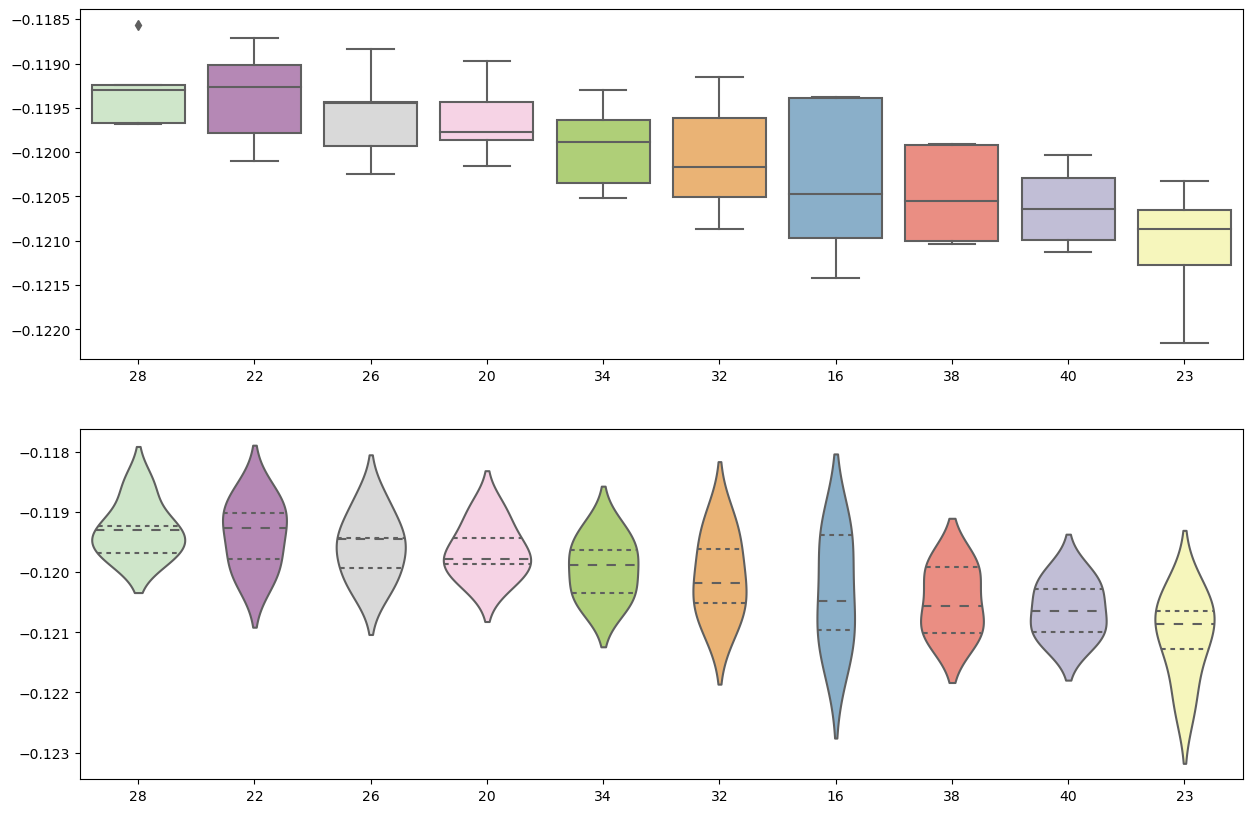

In [20]:
mask = grid_result.index[grid_result.index.str.endswith("_test_score")][:-3]
tabl = grid_result.loc[mask].iloc[:,:10]
f, ax = plt.subplots(2,1,figsize=(15, 10))
sns.boxplot(data=tabl,  linewidth=1.5, palette="Set3_r", ax=ax[0]);
sns.violinplot(data=tabl, inner="quart", linewidth=1.5, palette="Set3_r", ax=ax[1])

### Фичу модель и смотрю результаты

Max Error: 1
 
----------------------
   MAPE Error: 11.70
----------------------


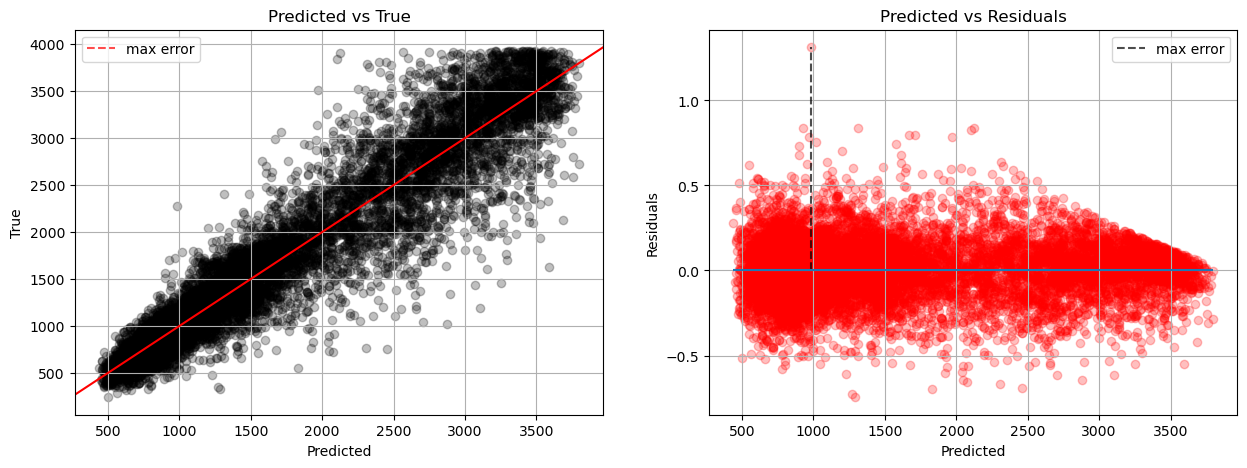

In [21]:
final.fit(X_train, y_train)
plot_2_error(y_test, final.predict(X_test))